In [3]:
import re

layer_re = re.compile(
    r"INFO layer (\d+?) iter (\d+?) loss:(nan|[\.\d]+?) norm:(nan|[\.\d]+?) max memory_allocated ([\.\d]+)")
task_re = re.compile(r"INFO \{.*?'results': (.+?), 'versions'")
ppl_re = re.compile(r"INFO (wikitext2|(?:ptb|c4)(?:-new)?) : ([\.\d]+)")

test_layer_re = "[2025-03-11 17:27:43 root] (RLQuant.py 236): INFO layer 0 iter 0 loss:0.023954108357429504 norm:0.28997743129730225 max memory_allocated 16404.5771484375 \n"
print(layer_re.search(test_layer_re).groups())

test_task_re = "[2025-03-27 15:32:14 root] (main.py 201): INFO {'wikitext2': 19.50642967224121, 'ptb': 104.68843078613281, 'c4': 23.896516799926758, 'ptb-new': 118.22755432128906, 'c4-new': 25.69214630126953, 'results': {'arc_challenge': {'acc': 0.2440273037542662, 'acc_stderr': 0.012551447627856262, 'acc_norm': 0.28924914675767915, 'acc_norm_stderr': 0.013250012579393443}, 'arc_easy': {'acc': 0.37962962962962965, 'acc_stderr': 0.009958037725468561, 'acc_norm': 0.3404882154882155, 'acc_norm_stderr': 0.009723676813825877}, 'hellaswag': {'acc': 0.35660227046405096, 'acc_stderr': 0.004780169873332848, 'acc_norm': 0.43168691495717987, 'acc_norm_stderr': 0.004942990623131105}, 'boolq': {'acc': 0.6033639143730887, 'acc_stderr': 0.008556148582031997}, 'piqa': {'acc': 0.6011969532100109, 'acc_stderr': 0.011424390545037282, 'acc_norm': 0.5984766050054406, 'acc_norm_stderr': 0.011437324373397846}, 'winogrande': {'acc': 0.5280189423835833, 'acc_stderr': 0.01403040421340578}}, 'versions': {'arc_challenge': 0, 'arc_easy': 0, 'hellaswag': 0, 'boolq': 1, 'piqa': 0, 'winogrande': 0}, 'config': {'model': <models.LMClass.LMClass object at 0x7b9b10dd7a90>, 'model_args': None, 'num_fewshot': 0, 'limit': None, 'bootstrap_iters': 100000, 'description_dict': None}}"
test_task_re_result = task_re.search(test_task_re).groups()[0]
print(eval(test_task_re_result))

test_ppl_re = "[2025-03-17 09:45:40 root] (main.py 186): INFO wikitext2 : 12.18686580657959"
print(ppl_re.search(test_ppl_re).groups())

('0', '0', '0.023954108357429504', '0.28997743129730225', '16404.5771484375')
{'arc_challenge': {'acc': 0.2440273037542662, 'acc_stderr': 0.012551447627856262, 'acc_norm': 0.28924914675767915, 'acc_norm_stderr': 0.013250012579393443}, 'arc_easy': {'acc': 0.37962962962962965, 'acc_stderr': 0.009958037725468561, 'acc_norm': 0.3404882154882155, 'acc_norm_stderr': 0.009723676813825877}, 'hellaswag': {'acc': 0.35660227046405096, 'acc_stderr': 0.004780169873332848, 'acc_norm': 0.43168691495717987, 'acc_norm_stderr': 0.004942990623131105}, 'boolq': {'acc': 0.6033639143730887, 'acc_stderr': 0.008556148582031997}, 'piqa': {'acc': 0.6011969532100109, 'acc_stderr': 0.011424390545037282, 'acc_norm': 0.5984766050054406, 'acc_norm_stderr': 0.011437324373397846}, 'winogrande': {'acc': 0.5280189423835833, 'acc_stderr': 0.01403040421340578}}
('wikitext2', '12.18686580657959')


In [4]:
import os


def get_model_result(model_log_path) -> dict | None:
    result = {}
    for log_filename in os.listdir(model_log_path):
        if log_filename.endswith(".pth"):
            continue

        log_path = os.path.join(model_log_path, log_filename)
        # print(f"processing file {log_path}")

        with open(log_path, "r") as log_file:
            tasks, ppl, layers = None, None, None

            while line := log_file.readline():
                if match_result := task_re.search(line):
                    task_result = eval(match_result.groups()[0])
                    tasks = task_result
                elif match_result := ppl_re.search(line):
                    if ppl is None:
                        ppl = []

                    ppl_dataset, value = match_result.groups()
                    ppl.append((ppl_dataset, float(value)))
                elif match_result := layer_re.search(line):
                    if layers is None:
                        layers = {}

                    layer, iter, loss, norm, max_memory_allocated = (
                        match_result.groups()
                    )
                    layers.setdefault(int(layer), []).append(
                        (loss, norm, max_memory_allocated)
                    )

            if tasks is not None:
                result.setdefault("tasks", []).append(tasks)
            if ppl is not None:
                result.setdefault("ppl", []).append(ppl)
            if layers is not None:
                result.setdefault("layers", []).append(layers)

    if len(result) == 0:
        return None
    return result


def get_results(
    log_dir_path,
    model_prefix="",
    allowd_models: list[str | re.Pattern] | None = None,
    ignore_models: list[str | re.Pattern] | None = None,
):
    results = {}

    for dir_entry in os.scandir(log_dir_path):
        if not dir_entry.is_dir():
            continue

        model_name = dir_entry.name[len(model_prefix) :]
        if allowd_models is not None and all(
            (
                re.search(regex, model_name) is None
                if isinstance(regex, re.Pattern)
                else regex != model_name
            )
            for regex in allowd_models
        ):
            continue
        if ignore_models is not None and any(
            (
                re.search(regex, model_name) is not None
                if isinstance(regex, re.Pattern)
                else regex == model_name
            )
            for regex in ignore_models
        ):
            continue

        model_path = os.path.join(os.getcwd(), log_dir_path, dir_entry.name)
        model_result = get_model_result(model_path)
        if model_result is not None:
            results.setdefault(model_name, model_result)
    return results

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def get_task_model_dict(results):
    task_model_dict = {}
    for key, item in sorted(results.items()):
        if not "tasks" in item or len(item["tasks"]) == 0: continue
        
        tasks = item["tasks"][0]
        for task_name, task_result in sorted(tasks.items()):
            if not task_name in task_model_dict:
                task_model_dict.setdefault(task_name, [])

            task_model_dict[task_name].append((key, task_result['acc']))
    return task_model_dict

# fp_16_results = {
#     "piqa": 0.7845,
#     "arc_easy": 0.6932,
#     "arc_challenge": 0.4002,
#     "boolq": 0.7107,
#     "hellaswag": 0.5669,
#     "winogrande": 0.6725,
# }
# # base_results = {
# #     "piqa": 0.6371,
# #     "arc_easy": 0.4696,
# #     "arc_challenge": 0.2627,
# #     "boolq": 0.6339,
# #     "hellaswag": 0.4442,
# #     "winogrande": 0.5319
# # }
def plot_task_results(results, diff_base=None):
    task_model_dict = get_task_model_dict(results)
    fig = plt.figure(constrained_layout=True, figsize=(20, 10))

    for idx, (task, model_result) in enumerate(task_model_dict.items()):
        ax = fig.add_subplot(2, len(task_model_dict)//2, (idx+1))
        ax.set_title(task)

        if diff_base is None:
            base_result = next(
                (value for name, value in model_result if name == diff_base), None)
        
        # model_result = [("fp16", fp_16_results[task]), *model_result]
        names, values = zip(*((name, value) for name, value in model_result))
        values = np.array(values)

        if base_result is not None:
            values_diff = (values - base_result)*100
        else:
            values_diff = values*100
        
        ax.set_xlim(xmin=(min(values_diff)*9/10), xmax=(max(values_diff)*11/10))
        barh = ax.barh(names, values_diff, align='center', alpha=0.5)
        ax.bar_label(barh, label_type='center')

    plt.show()

In [6]:
def get_ppl_model_dict(results):
    ppl_model_dict = {}
    for key, item in sorted(results.items()):
        if not "ppl" in item or len(item["ppl"]) == 0:
            continue

        ppl = item["ppl"][0]
        for ppl_name, ppl_result in sorted(ppl, key=lambda x: x[0]):
            if not ppl_name in ppl_model_dict:
                ppl_model_dict.setdefault(ppl_name, [])

            ppl_model_dict[ppl_name].append((key, ppl_result))
    return ppl_model_dict

# base_results = {
#     "wikitext2": 12.75,
#     "ptb": 87.63,
#     "c4": 15.82,
#     "ptb-new": 281.41,
#     "c4-new": 17.57,
# }
def plot_ppl_results(results, diff_base=None):
    ppl_model_dict = get_ppl_model_dict(results)
    fig = plt.figure(constrained_layout=True, figsize=(20, 10))

    for idx, (ppl_name, model_result) in enumerate(ppl_model_dict.items()):
        ax = fig.add_subplot(2, (len(ppl_model_dict)+1)//2, (idx+1))
        ax.set_title(ppl_name)
        ax.set_ylabel("PPL")

        if diff_base is None:
            base_result = next(
                (value for name, value in model_result if name == diff_base), None)
        
        # model_result = [("fp16", fp_16_results[ppl_name]), *model_result]
        names, values = zip(*((name, value) for name, value in model_result))
        values = np.array(values)

        if base_result is not None:
            values_diff = (values - base_result)
        else:
            values_diff = values
        
        ax.set_xlim(xmin=(min(values_diff)*9/10), xmax=(max(values_diff)*11/10))
        barh = ax.barh(names, values_diff, align='center', alpha=0.5)
        ax.bar_label(barh, label_type='center')

    plt.show()

In [8]:
def plot_layer_loss(results):
    plt.figure(figsize=(20, 10))
    plt.title("Layer Loss")
    plt.xlabel("Layer")
    plt.ylabel("Loss")
    plt.xticks(np.arange(0, 33, 1))
    plt.grid(True, axis="both")

    for model_name, model_result in results.items():
        if "layers" not in model_result or len(model_result["layers"]) == 0:
            continue

        for layers in model_result["layers"]:
            loss = []
            layer_labels = []
            for layer, values in layers.items():
                loss += [float(value[0]) for value in values]
                layer_labels += [
                    layer + iter_index / len(values) for iter_index in range(len(values))
                ]
            plt.plot(layer_labels, loss, label=model_name)

    plt.legend()
    plt.show()

{'without_no_grad-sw-each': {'layers': [{31: [('1.0776140689849854', 'nan', '13235.61572265625'), ('0.8722056746482849', 'nan', '13235.61669921875'), ('0.5081133842468262', '26.466533660888672', '13235.61669921875'), ('0.2844359278678894', '17.138967514038086', '13235.61669921875'), ('0.21260032057762146', '9.811986923217773', '13235.61669921875'), ('0.18538376688957214', '4.327477931976318', '13235.61669921875'), ('0.1733315885066986', '3.105353832244873', '13235.61669921875'), ('0.16741642355918884', '2.5041584968566895', '13235.61669921875'), ('0.1637369990348816', '2.0686237812042236', '13235.61669921875'), ('0.1597634106874466', '1.6558146476745605', '13235.61669921875'), ('0.15642423927783966', '1.2726324796676636', '13235.61669921875'), ('0.15392282605171204', '0.9837977886199951', '13235.61669921875'), ('0.15191496908664703', '0.8724510669708252', '13235.61669921875'), ('0.14967012405395508', '0.678260087966919', '13235.61669921875'), ('0.1479955017566681', '0.6289846301078796'

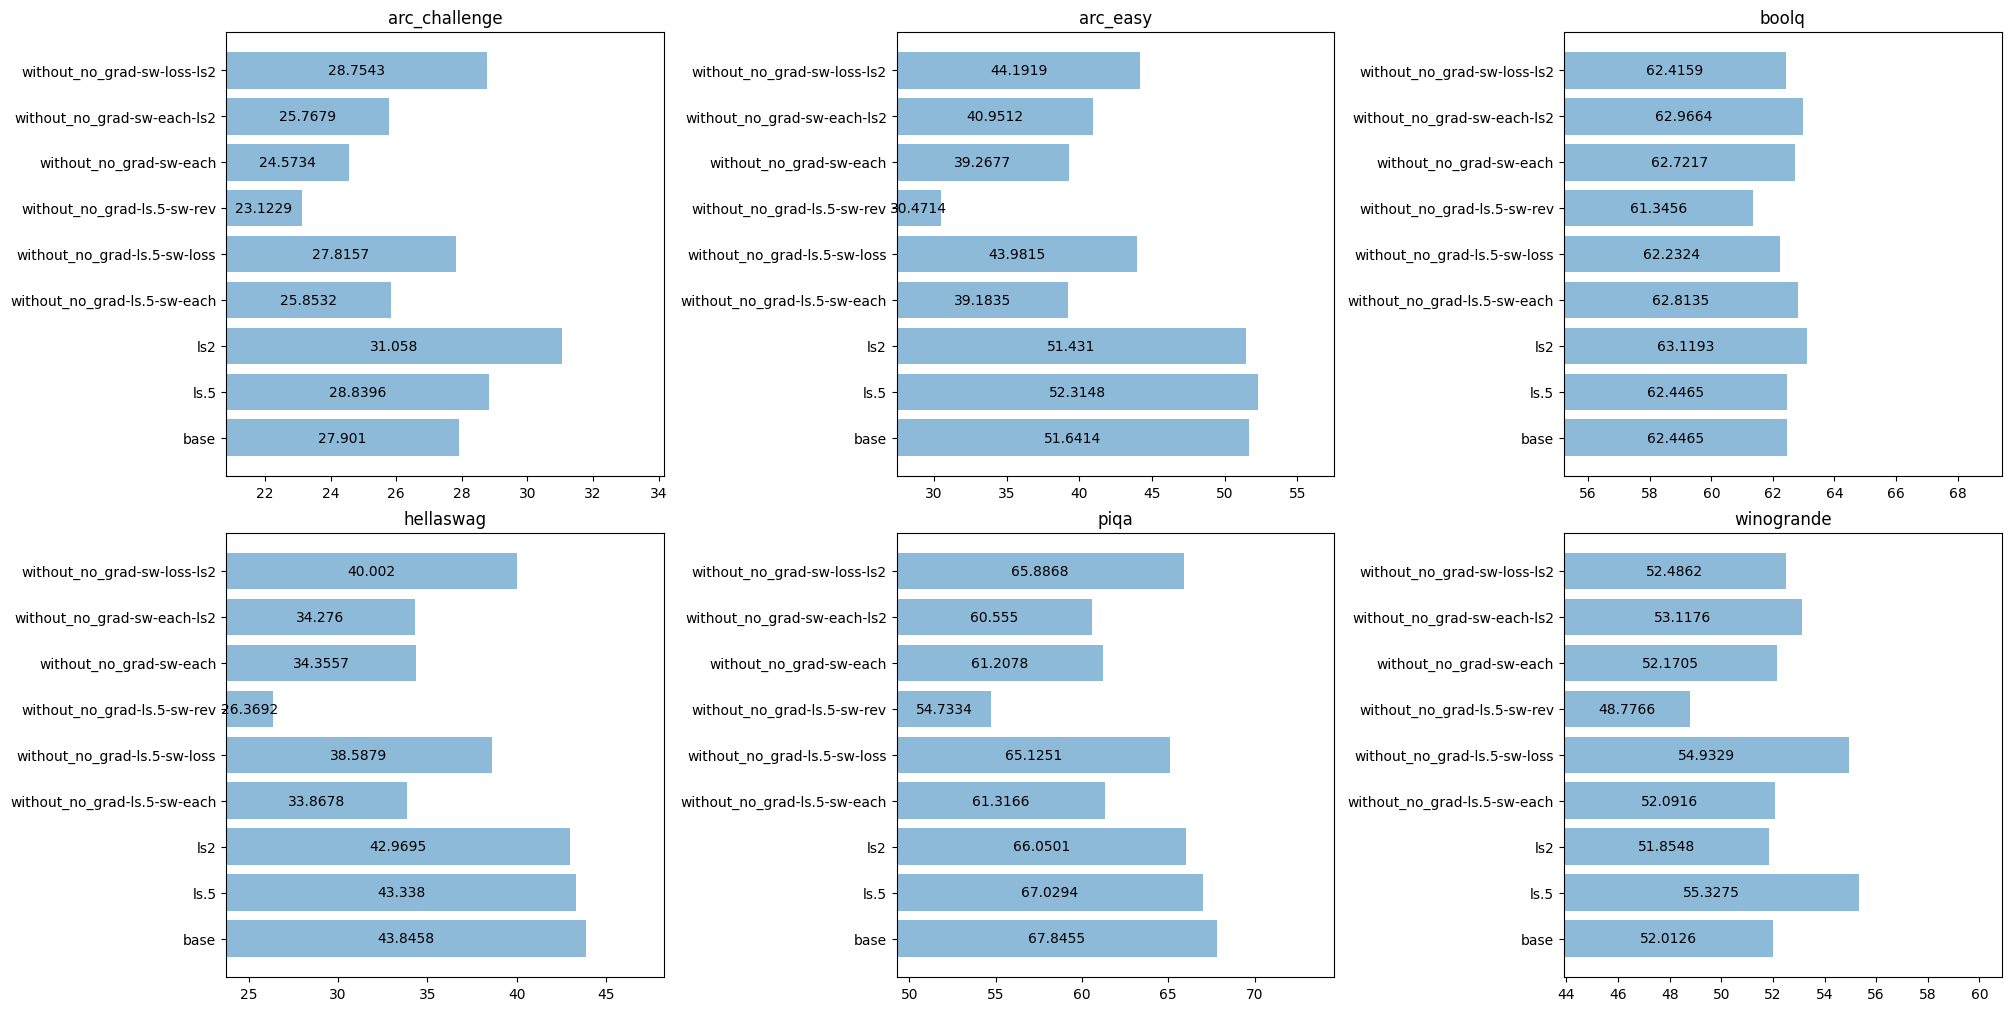

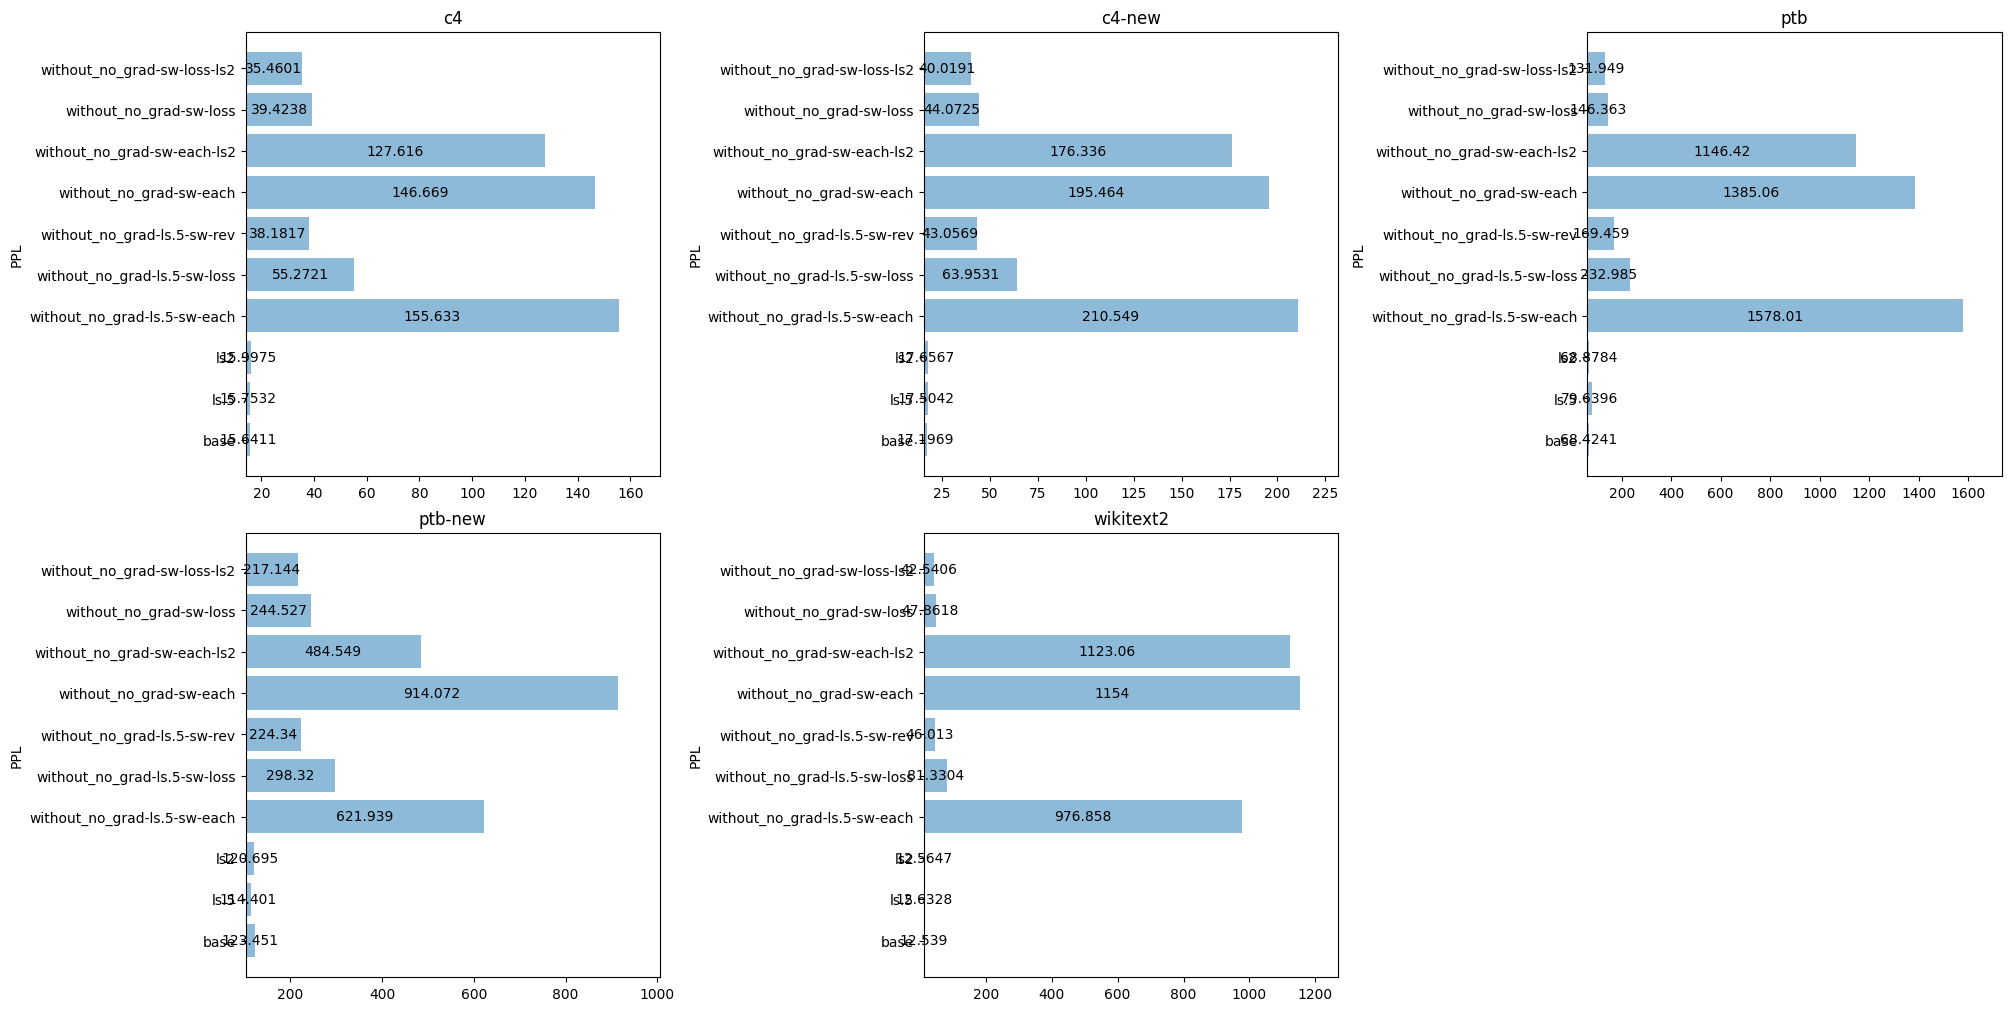

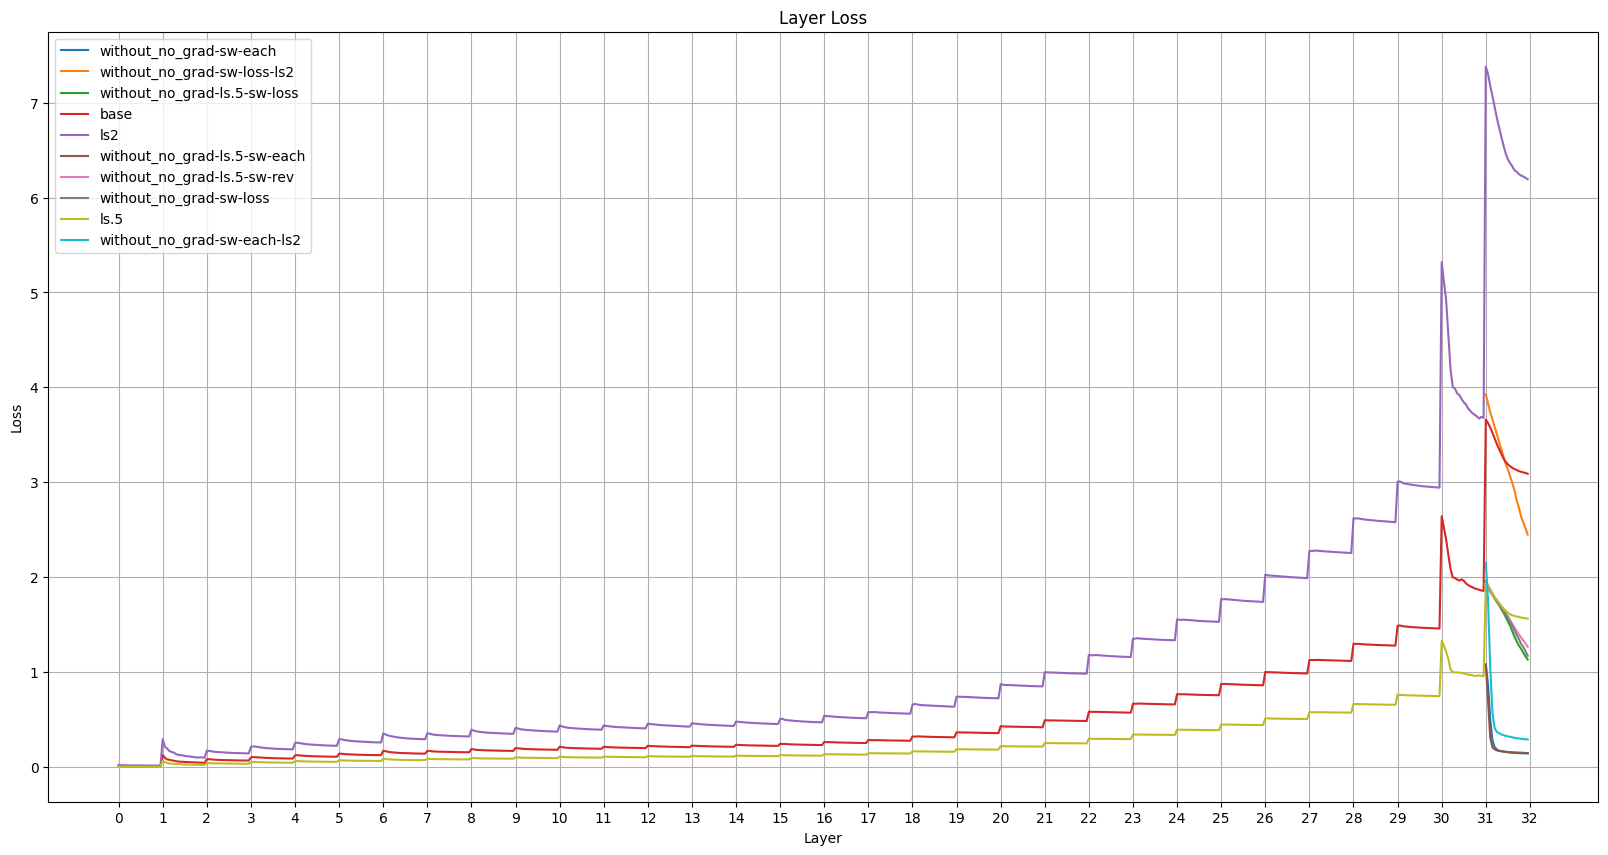

In [9]:
results = get_results(
    log_dir_path="../log/tuned",
    # model_prefix="llama-2-7b-hf-w4a4-",
    allowd_models=[
        "base",
        "ls.5",
        "ls2",
        re.compile('^without_no_grad'),
    ],
    # ignore_models=[
    #     re.compile("^sw"),
    #     re.compile("^ls.5-sw"),
    # ],
)
print(results)
plot_task_results(results)
plot_ppl_results(results)
plot_layer_loss(results)

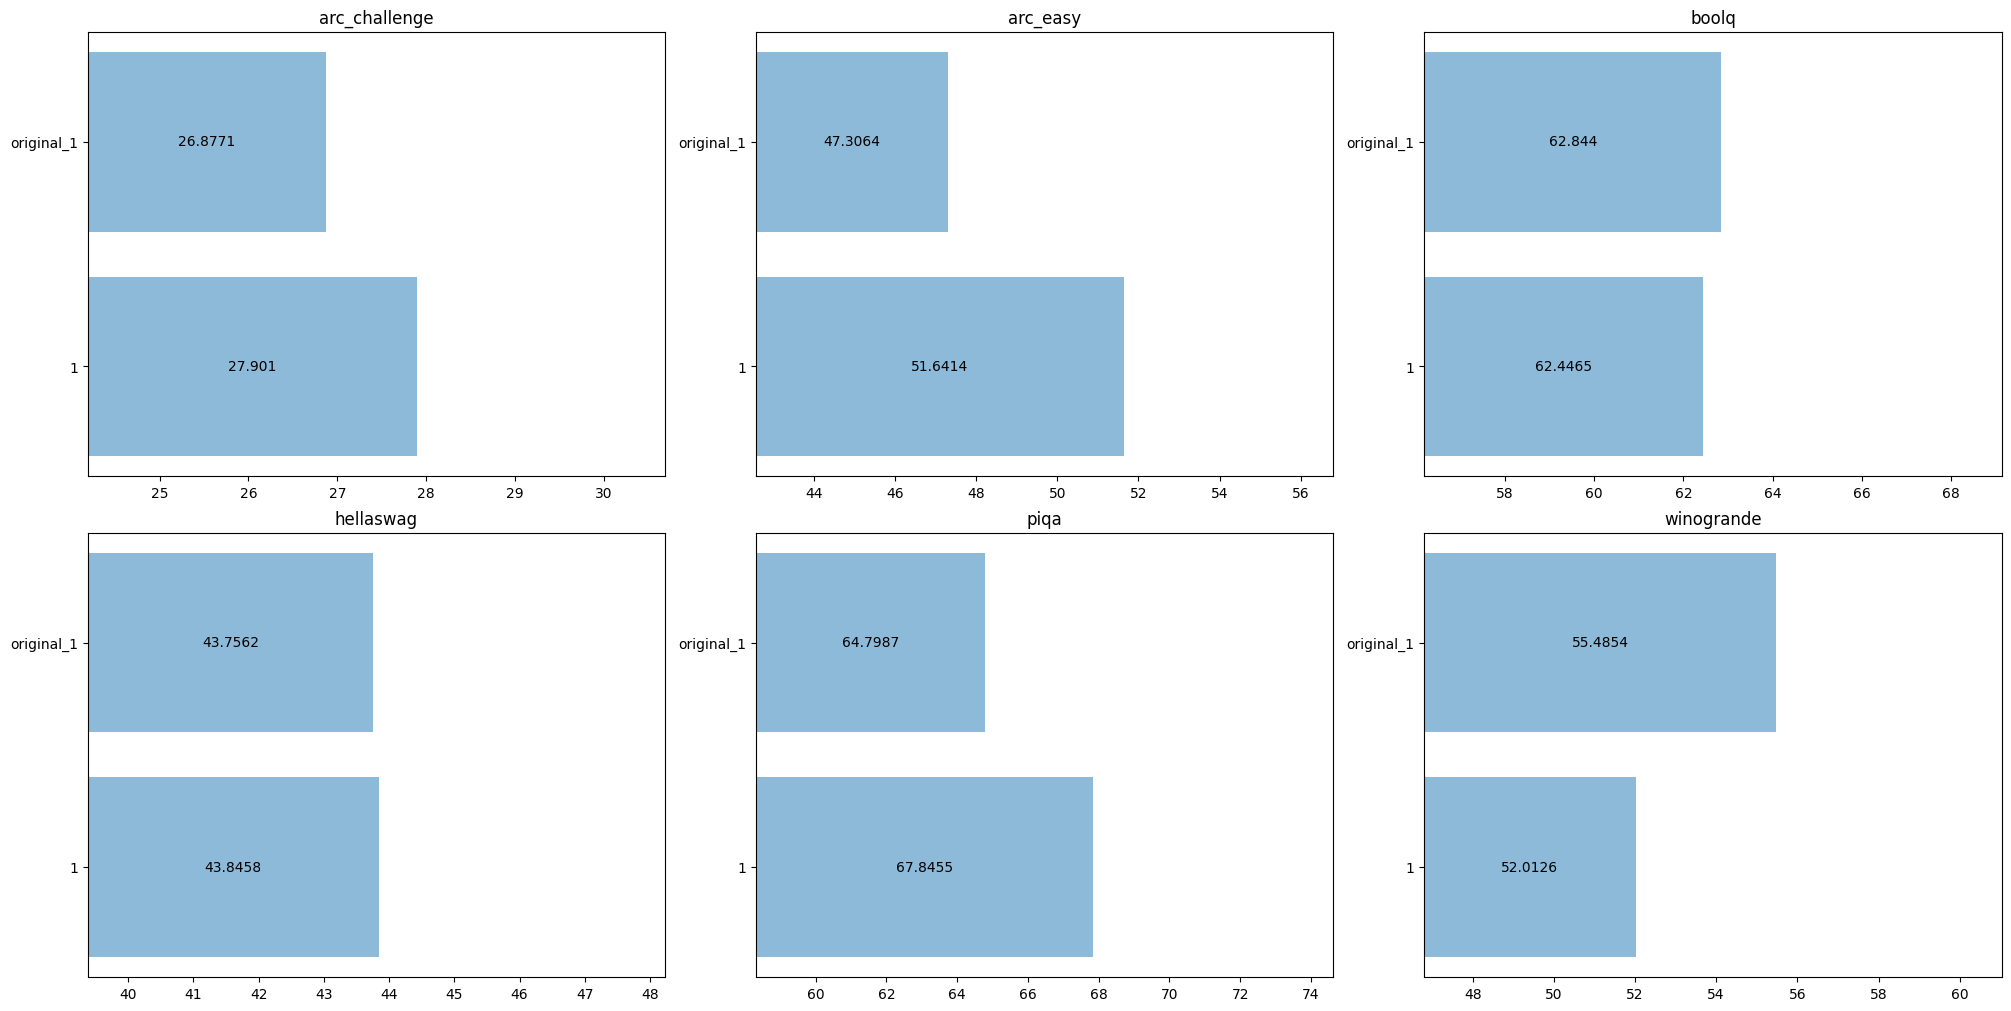

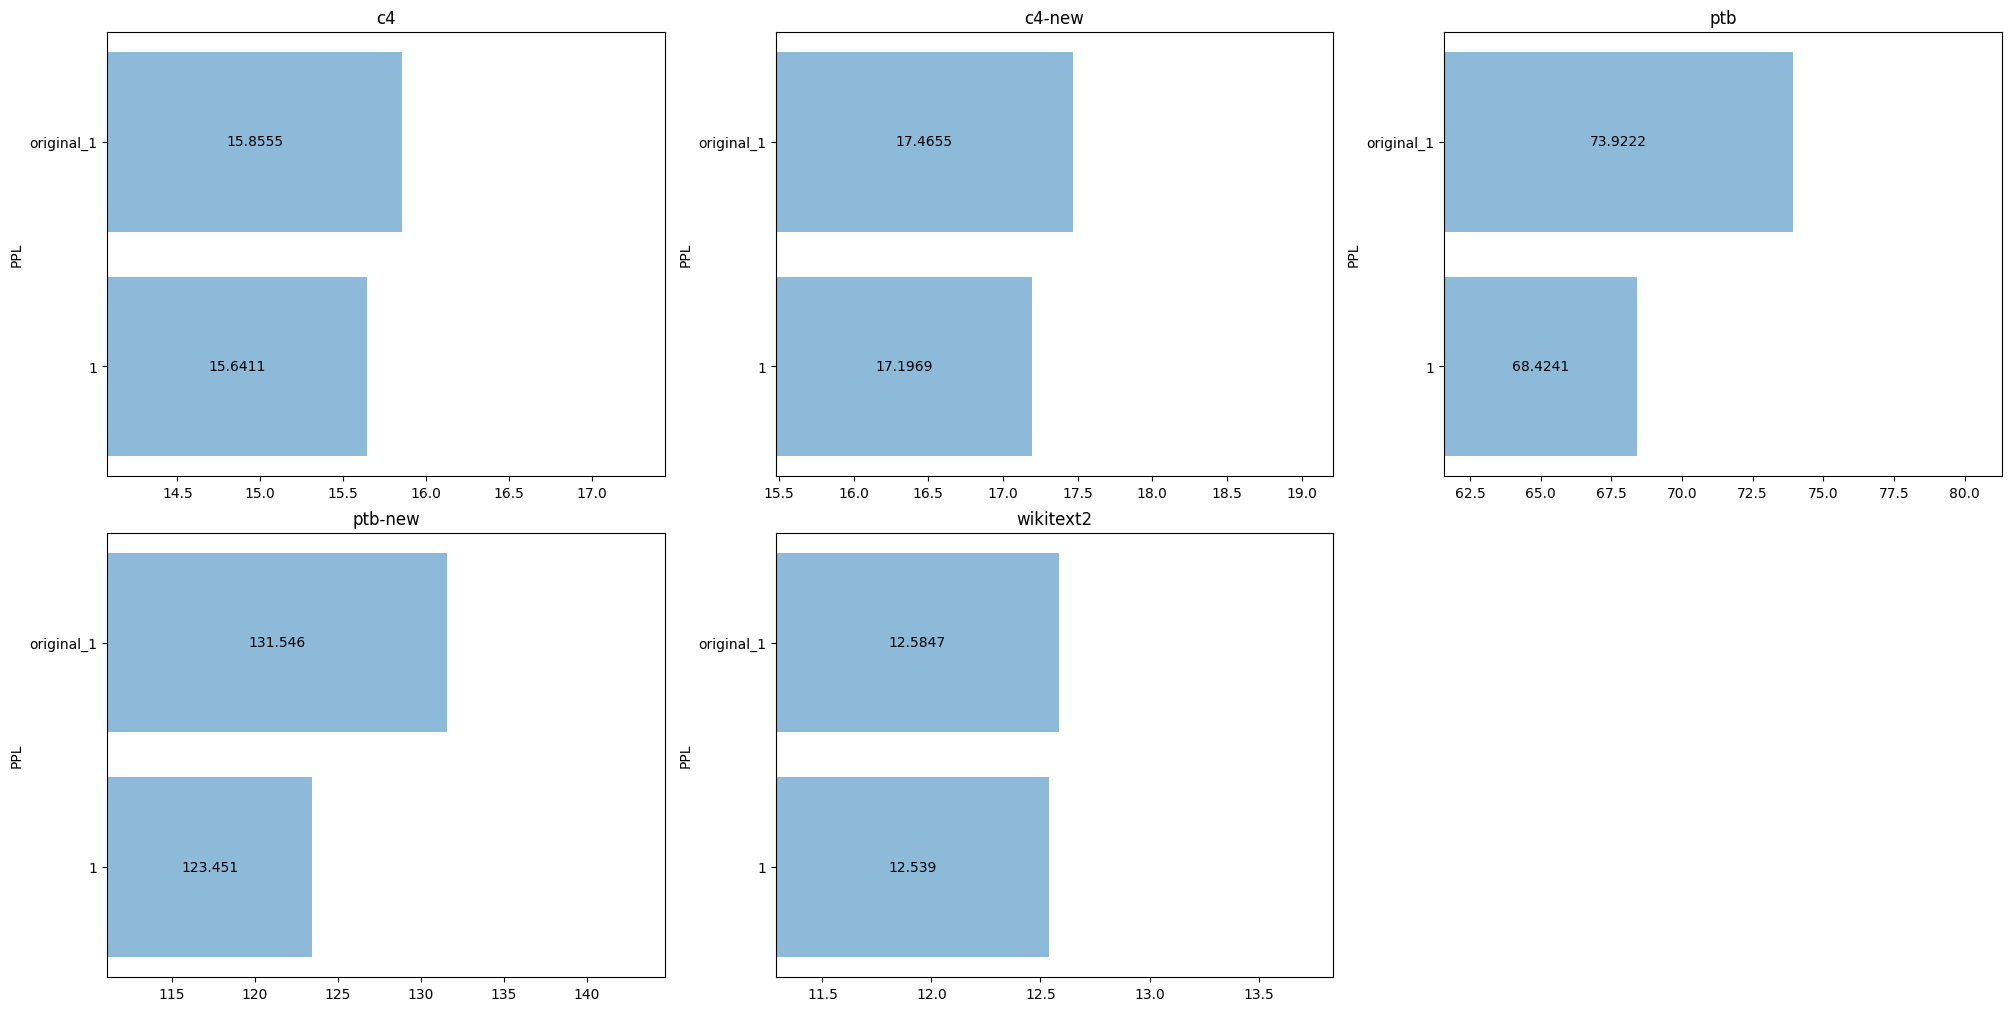

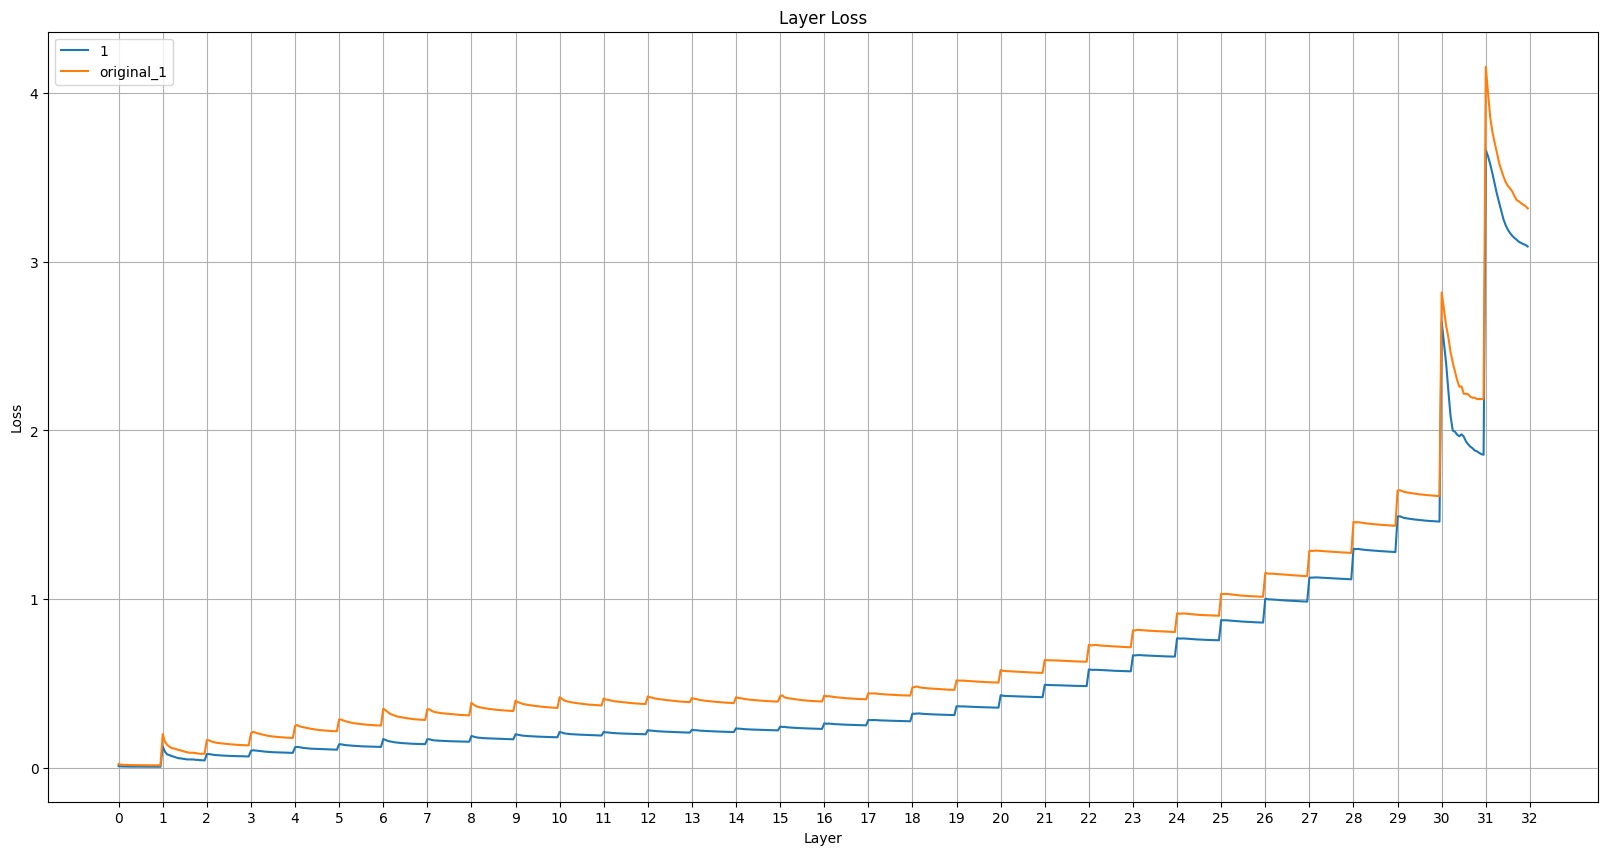

In [10]:
base_results = get_results(
    log_dir_path="../log/base",
)
plot_task_results(base_results)
plot_ppl_results(base_results)
plot_layer_loss(base_results)

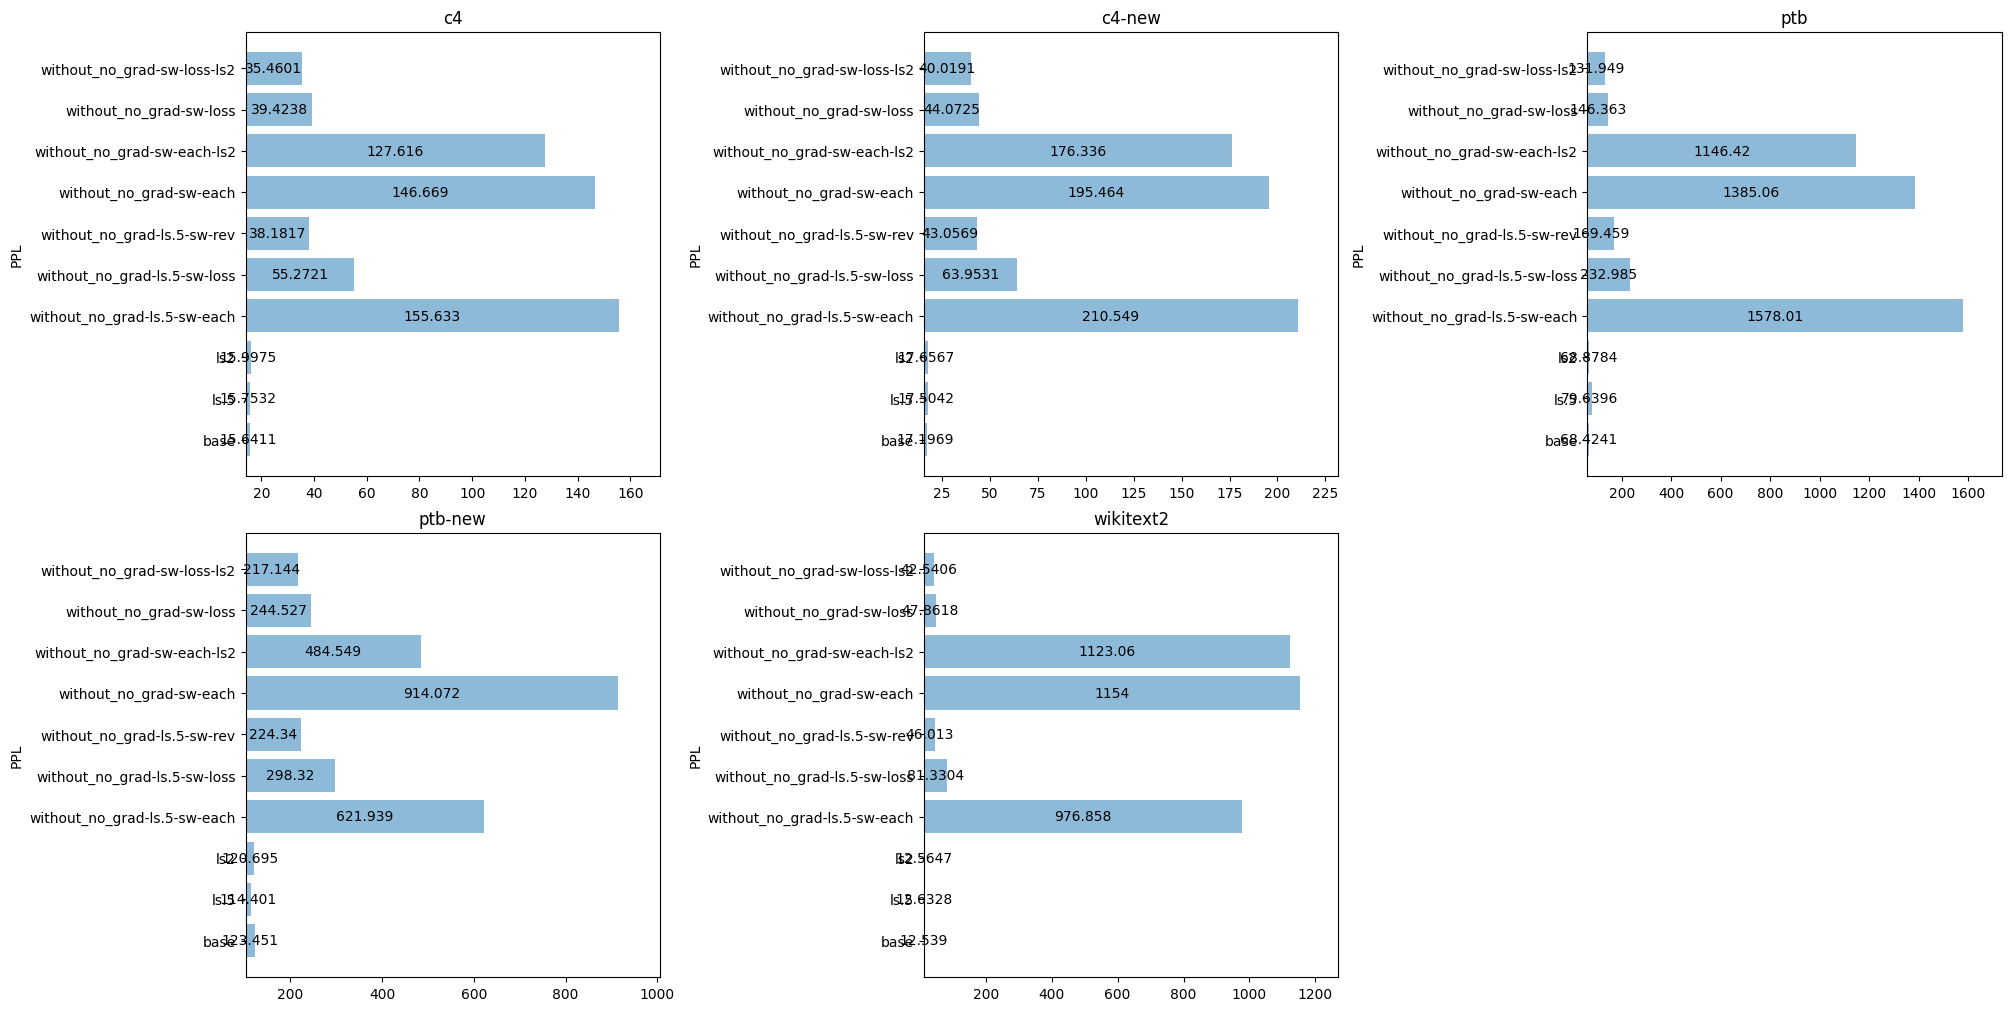

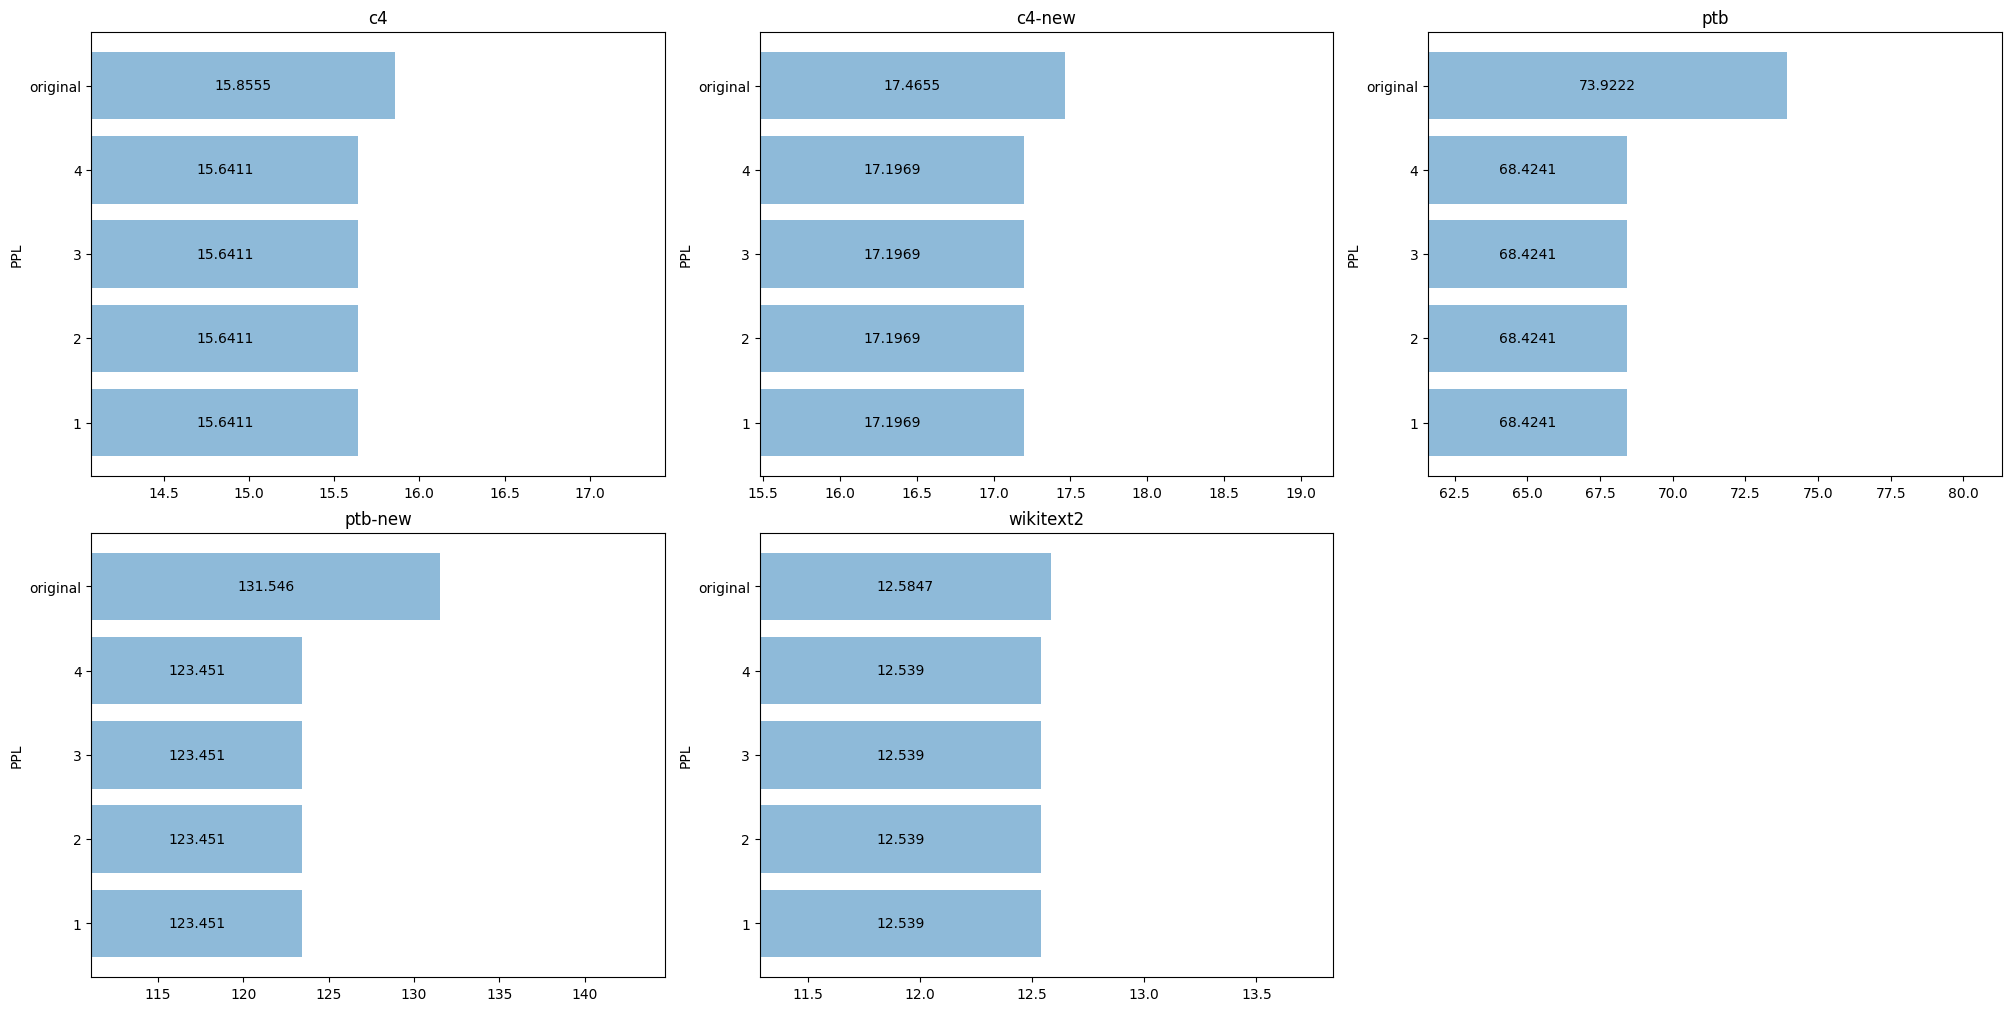

In [ ]:
model_results = get_results(
    log_dir_path="../log/base",
)
plot_task_results(model_results)
plot_ppl_results(model_results)
plot_layer_loss(model_results)